## Imports

Import all relevant libraries and local code.

In [33]:
from typing import Tuple, List, Union, Dict, Any
import sys
import os
import uuid
import random

# Include subpath as module path
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

print("Using local module path: ", module_path)

from stream_handler import setup
setup()

import backend.disorientationdetectors as detectors
import backend.datastructures as ds 
import backend.utils as utils
import backend.plotutils as plotutils
import backend.staypointdetector as spdetector
import backend.geohashsequenceinterpolator as ip
import backend.datapointstreamhandler as shandler
import backend.xchanges as xchanges
import backend.trajectorysegmentor as segmentor 
import backend.dataframeinterfaces as dfinterfaces
import backend.detectorevaluator as evaluator

import backend.models as django_models
import backend.managers as django_managers

from django.conf import settings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import pandas as pd
import numpy as np
import seaborn as sns
import msgpack

# Set Django environment variable such that we are able
# to run Django inside a jupyter notebook
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

# Set the default matplotlib figure size
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# Seaborn plotting settings
sns.set_theme(style = "whitegrid")
sns.set_context("paper", font_scale = 1.75,  rc = {"lines.linewidth": 1.75})
cp = sns.color_palette("tab10")
cp_list = list(cp.as_hex())

# Set the number of bits that a single character encodes
# in a geohash
BITS_PER_CHAR = 2

# Set the default map center for plotting purposes
CENTER = [55.37356990358646, 10.40957265669214]

# Use a dummy identifier of a user
USER = "d1b0c137-1cd0-4430-ad88-4dc24c88f3ad"

Using local module path:  /home/nicklasxyz/Desktop/traj-dirs/rtdm/RealtimeTrajectoryDataMining/rtdm


## Experimental data

Read in the relevant experimental data for case study 1: A single geospatial trajectory.

In [24]:
dfs = evaluator.read_all("data/case_study_1.json")

# Display the contents of the dataframe that was read in:
# - Column 'df' contains       : Trajectories stored as a dataframes.
# - Column 'uid' contains      : Unique identifiers of the trajectories.
# - Column 'anomalous' contains: A specification of whether a particular
#                                trajectory was generated as being anomalous
#                                or not.
dfs[0]

,df,uid,anomalous
0,latitude longitude ...,d4000012-b927-427b-949f-c1d43b1e5623,False


## Preprocess the data

In the following we load the trajectory, one geospatial datapoint at a time, into a list/queue datastructure which is then processed to produce a compressed trajectory. That is, compress a trajectory by merging consecutive geospatial points into *stay points* if certain conditions hold. Through this process we obtain for each new stay point in the compressed trajectory:
- More robust geospatial latitude/longitude coordinates: The median of the coordinates of the geospatial points that are used to form the stay point is used as its location.  
- A weight equal to the duration of time between the first and last geospatial datapoint that is used to form the stay point.  


In [31]:
trajectories = []
for i in range(len(dfs)):
    for _, row in dfs[i].iterrows():
        
        df = row["df"]; df["external_timestamp"] = df.index

        # Instantiate an 'InMemoryMessageExchangeWrapper' for managing
        # an in-memory datastructure store
        exchange = xchanges.InMemoryMessageExchangeWrapper()

        # Instantiate a 'DataPointStreamHandler' for preprocessing
        # the given input trajectory contained in the Pandas dataframe
        # 'df'
        dpsh = shandler.InMemoryDataPointStreamHandler(
            **{
                "exchange": exchange,
                "max_merging_distance": 28,
                "max_radius": 100,
            },
        )

        # Insert in bulk all geospatial datapoints, contained in the 
        # trajectory, into a list/queue datastructure for processing
        detectors.bulk_insert_datapoint(
            df=df,
            user=user,
            exchange=exchange,
        )

        # Process the inserted geospatial datapoints
        trajectory = detectors.bulk_process_datapoint(
            user=USER,
            exchange=exchange,
            dpsh=dpsh,
        )
        if len(trajectory) == 1:
            trajectory[0].uid = uuid.UUID(df["uid"].iloc[0])
        else:
            raise ValueError(
                "Expected only a single trajectory to be contained in the list!"
            )
        trajectories.extend(trajectory)
print(f"A total of of {len(trajectories)} trajectories were loaded and processed!")

A total of of 1 trajectories were loaded and processed!


## Preprocessing result

Calculate the \%-reduction in number of geospatial datapoints contained in the new compressed/preprocessed trajectory in comparison to the original trajectory.


In [32]:
dps = []
for datapoint in trajectories[0].datapoints:
    if len(datapoint.datapoints) > 0:
        for dp in datapoint.datapoints:
            dps.append(dp)
    else:
        dps.append(datapoint)

print("Datapoints in original trajectory  : ", len(dps))
print("Datapoints in compressed trajectory: ", len(trajectories[0].datapoints))
print("%-Reduction in number of datapoints: ", 100 * float(
    len(dps) - len(trajectories[0].datapoints) 
) / float(len(dps)), "%")

Datapoints in original trajectory  :  1209
Datapoints in compressed trajectory:  390
%-Reduction in number of datapoints:  67.74193548387096 %


### Original trajectory (before preprocessing)

Plot the original trajectory on a map.

In [35]:
map_ = plotutils.setup_map(center)
for trajectory in trajectories:
    map_ = ds.Trajectory(dps).plot(center=CENTER, map_=map_)
map_

### Compressed trajectory (after preprocessing)
Plot the compressed/preprocessed trajectory on a map.

In [37]:
map_ = plotutils.setup_map(center)
for trajectory in trajectories:
    map_ = trajectories[0].plot(center=CENTER, map_=map_)
map_

## Determine geofenced regions

Based on the stay points that were created in the context of the preprocessing step, determine geofenced regions. The geofenced regions are created based on detected clusters of stay points that:
- (i) can be said to be in the vicinity of each other
- (ii) have a weight larger than a certain threshold

In [42]:
spd = spdetector.StayPointDetector(
    min_weight=600,
    radius=28,
    reference_user=USER,
    **{"exchange": exchange},
)
spd.fit(trajectories=trajectories, user=USER)
spd.plot(center=CENTER, map_=map_)

## Trajectory segmentation

Segment the compressed/preprocessed trajectory into smaller meaningful trajectories that go between geofenced regions.

Note: Make sure database tables have been created by running `python manage.py makemigrations && python manage.py migrate` in the main project directory `rtdm`.

In [51]:
# Convert the compressed/preprocessed trajectory into 
# a Django database model and save it
dp = trajectories[0].datapoints[0]
obj_list = []
traj_obj = django_models.Trajectory(
    start_timestamp=dp.external_timestamp,
    end_timestamp=None,
    user=USER,
    # Tag the trajectory data as "raw"
    tag="raw",
)
traj_obj.save()

# Convert the datapoints in the compressed/preprocessed 
# trajectory into Django database models as well and save
# them 
dps = trajectories[0].datapoints
traj_obj = django_models.Trajectory.objects.filter(user=USER).last()  
traj_obj.start_timestamp = dps[0].external_timestamp
traj_obj.end_timestamp = dps[-1].external_timestamp
traj_obj.save(update_fields = ["start_timestamp", "end_timestamp"])
for dp in dps:
    dp_ = django_models.DataPoint(
        latitude=dp.latitude,
        longitude=dp.longitude,
        user = uuid.UUID(user), 
        label = None, 
        external_timestamp = dp.external_timestamp, 
        weight = dp.weight,
        # Nested datapoints are just saved as extra msgpack byte data
        datapoints = msgpack.dumps([_.to_dict() for _ in dp.datapoints]), 
        dx = dp.dx, 
        dt = dp.dt, 
        speed = dp.speed, 
        acceleration = dp.acceleration, 
        accuracy = dp.accuracy, 
    )
    # Associate each datapoint with the trajectory
    setattr(dp_, "trajectory", traj_obj)
    dp_.save()

In [52]:
def from_model(datapoint):
    """Convert Python DataPoint object to a Django database model object.
    """
    dict_ = datapoint.__dict__.copy()
    dict_["external_timestamp"] = str(dict_["external_timestamp"]) 
    dict_["user"] = str(dict_["user"])
    dict_["trajectory"] = dict_["trajectory_id"] 
    return ds.DataPoint.from_dict(dict_)

traj = ds.Trajectory([])
traj.datapoints = [from_model(_) for _ in traj_obj.datapoints.all()]
traj.uid = str(trajectory.uid)
traj.color = trajectory.color
traj.trajectory = str(trajectory.trajectory)

In [53]:
onlinets = segmentor.TrajectorySegmentor(time_period="2.5T", **{"exchange": exchange})
onlinets._segment_trajectory_offline(user=USER, spd=spd, trajectories=[traj])
traj_obj = django_models.Trajectory.objects.filter(user = user).last()  
subtrajectories = onlinets._segment_trajectory(user, traj_obj)

Saving 'BreakPoint' for trajectory:  9456acc0-7174-4404-b37c-69c8247e75a1
Saving 'BreakPoint' for trajectory:  9456acc0-7174-4404-b37c-69c8247e75a1
Saving 'BreakPoint' for trajectory:  9456acc0-7174-4404-b37c-69c8247e75a1
Saving 'BreakPoint' for trajectory:  9456acc0-7174-4404-b37c-69c8247e75a1
Saving 'BreakPoint' for trajectory:  9456acc0-7174-4404-b37c-69c8247e75a1
Saving 'BreakPoint' for trajectory:  9456acc0-7174-4404-b37c-69c8247e75a1
Saving 'BreakPoint' for trajectory:  9456acc0-7174-4404-b37c-69c8247e75a1
Saving 'BreakPoint' for trajectory:  9456acc0-7174-4404-b37c-69c8247e75a1
Saving 'BreakPoint' for trajectory:  9456acc0-7174-4404-b37c-69c8247e75a1
Saving 'BreakPoint' for trajectory:  9456acc0-7174-4404-b37c-69c8247e75a1
Saving 'BreakPoint' for trajectory:  9456acc0-7174-4404-b37c-69c8247e75a1


## Trajectory segmentation

Plot all subtrajectories resulting from the segmentation

In [57]:
counter = 0
map_ = plotutils.setup_map(center)
for trajectory in subtrajectories:
    random.seed(counter)
    trajectory.color = f"#{utils.color_hex(utils.rand_24_bit())}" 
    map_ = trajectory.plot(center = center, map_ = map_)
    counter += 1
map_

## Final results

Plot the original trajectory (before preprocessing) in terms of a timeseries of longitude and latitude coordinates. Alongside the original trajectory, plot the preprocessed trajectory that have been compressed and segmented into several smaller meaningful (sub)-trajectories. 

In [54]:
# Store trajectory data in a dataframe for plotting
# purposes
data = []
for trajectory in trajectories:
    for datapoint in trajectory.datapoints:
        dict_ = {
            "latitude": datapoint.latitude,
            "longitude": datapoint.longitude,
            "external_timestamp": datapoint.external_timestamp,
            "uid": trajectory.uid,
            "sub": 0,
        }
        data.append(dict_)
traj_df = pd.DataFrame(data = data)

# Store all subtrajectory data in a dataframe for
# plotting purposes
data = []; counter = 1
for trajectory in subtrajectories:
    for datapoint in trajectory.datapoints:
        dict_ = {
            "latitude": datapoint.latitude,
            "longitude": datapoint.longitude,
            "external_timestamp": datapoint.external_timestamp,
            "uid": trajectory.uid,
            "sub": counter,
        }
        data.append(dict_)
    counter += 1
subtraj_df = pd.DataFrame(data = data)

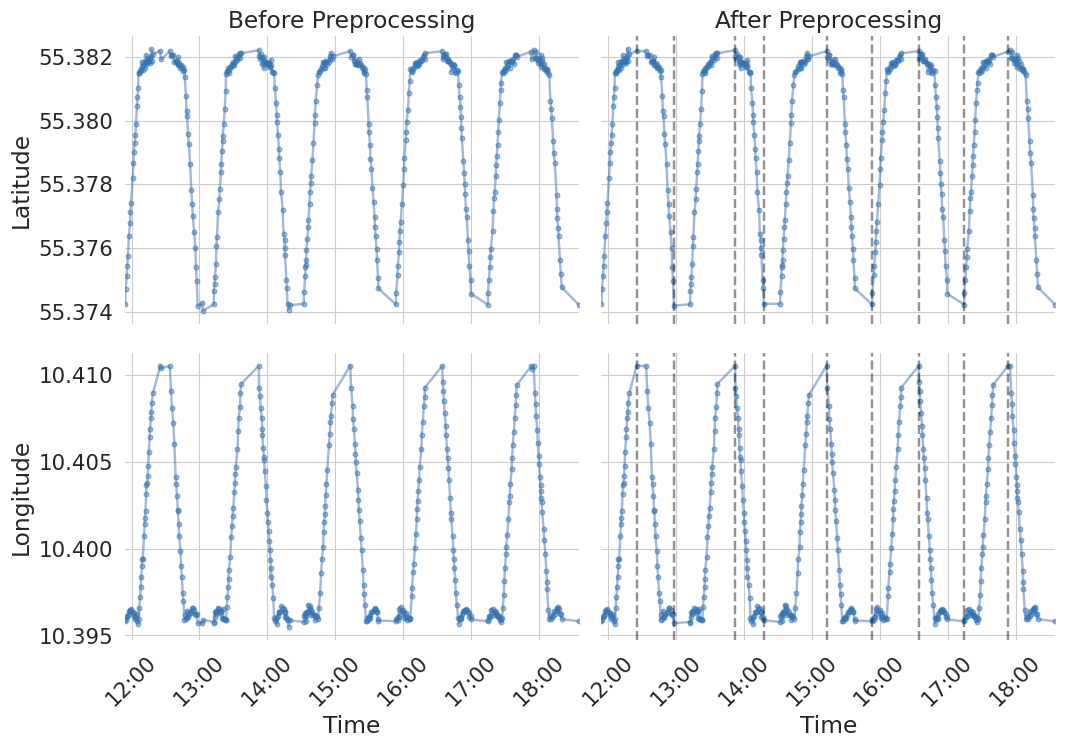

In [58]:
fig, axs = plt.subplots(2, 2, sharex = True, sharey = "row")

sns.lineplot(
    x = traj_df["external_timestamp"].values,
    y = traj_df["latitude"].values,
    dashes = False,
    ax = axs[0, 0],
    **{"marker": "o", "markersize": 3.5, "markeredgecolor": cp_list[0], "alpha": 0.5}
)

sns.lineplot(
    x = traj_df["external_timestamp"].values,
    y = traj_df["longitude"].values,
    dashes = False,
    ax = axs[1, 0],
    **{"marker": "o", "markersize": 3.5, "markeredgecolor": cp_list[0], "alpha": 0.5}
)

sns.lineplot(
    x = subtraj_df["external_timestamp"].values,
    y = subtraj_df["latitude"].values,
    dashes = False,
    ax = axs[0, 1],
    **{"marker": "o", "markersize": 3.5, "markeredgecolor": cp_list[0], "alpha": 0.5}
)
sns.lineplot(
    x = subtraj_df["external_timestamp"].values,
    y = subtraj_df["longitude"].values,
    dashes = False,
    ax = axs[1, 1],
    **{"marker": "o", "markersize": 3.5, "markeredgecolor": cp_list[0], "alpha": 0.5}
)

for _, _df in subtraj_df.groupby("sub"):
    if _ < 10:
        axs[0, 1].axvline(
            _df["external_timestamp"].values[-1],
            **{"color": "black", "alpha": 0.425, "linestyle": "--"},
        )
        axs[1, 1].axvline(
            _df["external_timestamp"].values[-1],
            **{"color": "black", "alpha": 0.425, "linestyle": "--"}
        )
    
axs[0, 0].set_ylabel("Latitude")
axs[1, 0].set_ylabel("Longitude")
axs[0, 0].set_title("Before Preprocessing")
axs[0, 1].set_title("After Preprocessing")

axs[1, 0].set_xlabel("Time")
axs[1, 1].set_xlabel("Time")

axs[1, 0].set_xlim(traj_df["external_timestamp"].values[0], traj_df["external_timestamp"].values[-1])
axs[1, 0].xaxis.set_major_locator(mdates.HourLocator())
axs[1, 0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
axs[1, 0].tick_params(axis = "x", rotation = 45)

axs[1, 1].set_xlim(traj_df["external_timestamp"].values[0], traj_df["external_timestamp"].values[-1])
axs[1, 1].xaxis.set_major_locator(mdates.HourLocator())
axs[1, 1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
axs[1, 1].tick_params(axis = "x", rotation = 45)

sns.despine(fig, left = True, bottom  = True, right = True, top = True)
plt.subplots_adjust(wspace=0.05, hspace=0.10)